In [1]:


import sys
import math
import numpy as np #v 1.23.3
import networkx as nx
import matplotlib.cm as cm
import matplotlib
import argparse
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from networkx.algorithms import community
import community
from community import community_louvain #conda install python-louvain
from PIL import Image
import os
import scipy
from numpy import roots
import random
import pickle
%matplotlib notebook

Making our ant agents as a data class. Here only giving one coord, so they take up one cell. Could give a head and tail coord so they are oblong if we wanted.

In [8]:
class Ant:
    def __init__(self, coord, heading, identity, twitch, active, move_speed, t1, t2):
        #self.orientation=orientation
        self.coord=coord
        self.heading=heading
        self.identity=identity
        self.twitch=twitch#just basic edge
        self.active=active
        self.move_speed=move_speed
        self.t1=t1
        self.t2=t2

This is our function to create agents. If we wanted to make a focal agent with a spores variable or something similar could add variable in class and add infected list here. In my other one I have a 'caste' variable but I am not sure what our predictions would be RE caste here.

In [188]:
def create_agents(ant_number, inoculated_number, move_speed):
    ants=[]
    inoculateds=[]
    A=0 #ant identity iterates up
    coord=np.nan
    directions = ['N', 'E', 'S', 'W']
    twitch=0
    active=0 
    move_speed=move_speed

    for a in range(0, ant_number):
        #randomly choose a starting heading
        random_direction = random.choice(directions)
        ant=Ant(coord, random_direction, A, twitch, active, move_speed, 0, 0)
        ants.append(ant)
        A+=1

    for a in range(0, inoculated_number):
        #randomly choose a starting heading
        random_direction = random.choice(directions)
        ant=Ant(coord, random_direction, A, twitch, active, move_speed, 0, 0)
        inoculateds.append(ant)
        A+=1
        
    return ants, inoculateds

In [189]:
ant_list, inoculated_list = create_agents(6, 0, 1)
print(ant_list) # now have 6 ants

[<__main__.Ant object at 0x7f28c5417b80>, <__main__.Ant object at 0x7f28c5417be0>, <__main__.Ant object at 0x7f28c5417970>, <__main__.Ant object at 0x7f28c5417c10>, <__main__.Ant object at 0x7f28c5417910>, <__main__.Ant object at 0x7f28c54178b0>]


First we make a matrix which is the 'petri'. Could make this circular if we felt useful as well. 0 will = no ant, 1= ant, 2= twitch ant. The other way I thought of doing it was making an array of lists which you add the ants to. But then it is a bit harder to shuffle interaction order and plot, even tho seems more intuitive.

In [160]:
n1 = 10
n2 = 10
matrix = np.zeros((n1, n2))
print(matrix)

# for i in range(n1):
#     for j in range(n2):
#         matrix[i,j] = []
# print(matrix)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [161]:
ant_list[1].twitch

0

In [162]:
matrix[5][2]#Indexing is done y, x. This is the 5th row, 2nd column

0.0

In [190]:
#INITIALIZATION - GIVE EACH ANT RANDOM COORDS
used_coords=[]
assigned_ids=[]
while len(used_coords)<len(ant_list):
    for ant in ant_list:
        x = np.random.randint(0, n2-1)
        y = np.random.randint(0, n1-1)
        coords=tuple([x,y])
        if coords not in used_coords and ant.identity not in assigned_ids:
            ant.coords=coords
            assigned_ids.append(ant.identity)
            used_coords.append(coords)
        else:
            continue
print(ant_list[1].coords) # can check assigning coords properly

(6, 0)


In [164]:
def turn_submodel(ant):    

        if ant.heading=='N':#we want to correlate their walk so they are less likely to turn 18- 
            #this may not be best way. should check turtle ant paper
            #also our ants cant move diagonally. would be easy to add. just need more headings.
            choices=['E', 'S', 'W']
            probabilities = [0.4, 0.2, 0.4]
            choice = random.choices(choices, probabilities)[0]
            ant.heading=choice
            # Print the chosen direction
            print(f"The ant turns {choice}")
        elif ant.heading=='S':
            choices=['E', 'N', 'W']
            probabilities = [0.4, 0.2, 0.4]
            choice = random.choices(choices, probabilities)[0]
            ant.heading=choice
            print(f"The ant turns {choice}")
        elif ant.heading=='E':
            choices=['S', 'W', 'N']
            probabilities = [0.4, 0.2, 0.4]
            choice = random.choices(choices, probabilities)[0]
            ant.heading=choice
            print(f"The ant turns {choice}")
        elif ant.heading=='W':
            choices=['S', 'E', 'N']
            probabilities = [0.4, 0.2, 0.4]
            choice = random.choices(choices, probabilities)[0]
            ant.heading=choice
            print(f"The ant turns {choice}")
        return ant


In [191]:
def movement_submodel (ant, ant_list,Pturn):
    if Pturn>random.random():
        ant=turn_submodel(ant)
    ant_list2=[]

        
    if ant.heading=='N':
        y, x=ant.coords
        if y-1<0: #if it hits a north wall
            ant=turn_submodel(ant)
        else:
            new_coords=tuple([y-1, x])
            for ant2 in ant_list:
                if ant2.coords==new_coords:
                    ant=turn_submodel(ant)
                    continue
            ant.coords=new_coords
    if ant.heading=='S':
        y, x=ant.coords
        if y+1>n1-1: #if it hits a north wall
            ant=turn_submodel(ant)
        else:
            new_coords=tuple([y+1, x])
            for ant2 in ant_list:
                if ant2.coords==new_coords:
                    ant=turn_submodel(ant)
                    continue
            ant.coords=new_coords
        
    if ant.heading=='E':
        y, x=ant.coords
        if x+1>n1-1: #if it hits a north wall
            ant=turn_submodel(ant)
        else:
            new_coords=tuple([y, x+1])
            for ant2 in ant_list:
                if ant2.coords==new_coords:
                    ant=turn_submodel(ant)
                    continue
            ant.coords=new_coords
        
    if ant.heading=='W':
        y, x=ant.coords
        if x-1<0: #if it hits a north wall
            ant=turn_submodel(ant)
        else:
            new_coords=tuple([y, x-1])
            for ant2 in ant_list:
                if ant2.coords==new_coords:
                    ant=turn_submodel(ant)
                    continue
            ant.coords=new_coords
    return ant

In [166]:
ant=ant_list[2]
print(ant.coords)
print(ant.heading)
ant2=movement_submodel(ant, ant_list)


(8, 1)
N
The ant turns E
(8, 2)
E


In [179]:
def is_adjacent(ant1, ant2):
    x1, y1 = ant1
    x2, y2 = ant2
    if abs(x1 - x2) <= 1 and abs(y1 - y2) <= 1:
        is_adj=True
    else:
        is_adj=False
    return is_adj

In [180]:
Pturn=0.2
Pmove=0.95#probability that an ant will move - maybe we want to make it 'sticky',
#so if an ant moved it is more likely to continue moving
tmax=50
Ptwitch=0.05
twitch_time=0.1
active_move_speed=2
move_speed=1
active_time=1

In [186]:
# now run: can add while its<its here
list_matrix=[]
t=0
while t<tmax:
    #first we define if an ant turns
    #ant_list=list(random.shuffle(ant_list)) # shuffle tunr and move order
    ant_list2=[]
    for ant in ant_list:
        #this decides if an ant will turn or not. maybe we want to increase if ant at wall
        if Pmove>random.random():
            move_time=0
            while move_time <ant.move_speed: # this accounts for movement speed
                ant=movement_submodel(ant, ant_list, Pturn)
                move_time+=1
        ant_list2.append(ant)       

    # now we do twitching. at each t. an ant has a probability to twitch - we can change this
    ant_list=ant_list2

    t_next=t+1
    while t<t_next:
        random.shuffle(ant_list) 
        ant_list_copy=[]
        for ant in ant_list:
            ant_list2=[]
            if ant.t1<t:
                ant.twitch=0
            if ant.t2<t:
                ant.active=0
                ant.move_speed=move_speed
            
            for a in ant_list:
                if a != ant:
                    ant_list2.append(ant)


            Ptwitch2=Ptwitch
            for a in ant_list2:
                is_adj=is_adjacent(ant.coords, a.coords)
            if  is_adj==True:
                if a.twitch==1:
                    Ptwitch2=Ptwitch*2 
                        #could activate here also
            # this just makes it more likely to twitch if an adjacent ant is twitching

            if ant.twitch==0 and random.random()<Ptwitch2:
                ant.twitch=1
                ant.t1=t+twitch_time
                ant.active=1
                
                ant.move_speed=active_move_speed
                ant.t2=t+active_time
            ant_list_copy.append(ant)
            t+=0.1 #can also be twitch timescale or something
        ant_list=ant_list_copy
        matrix_shape = (n1, n2)
        matrix2 = np.zeros(matrix_shape)    

        for ant in ant_list:
            x, y = ant.coords
            if ant.twitch==1:
        
                matrix2[y, x] = 3
            elif ant.active==1:
                matrix2[y, x] = 2
            else:
                matrix2[y, x] = 1

        list_matrix.append(matrix2)
        


    t+=1

The ant turns W
The ant turns N
The ant turns N
The ant turns E
The ant turns S
The ant turns S
The ant turns E
The ant turns W
The ant turns S
The ant turns W
The ant turns W
The ant turns N
The ant turns W
The ant turns N
The ant turns W
The ant turns S
The ant turns S
The ant turns W
The ant turns S
The ant turns E
The ant turns N
The ant turns N
The ant turns W
The ant turns W
The ant turns E
The ant turns E
The ant turns S
The ant turns N
The ant turns E
The ant turns E
The ant turns W
The ant turns E
The ant turns N
The ant turns N
The ant turns W
The ant turns N
The ant turns W
The ant turns W
The ant turns E
The ant turns N
The ant turns S
The ant turns W
The ant turns E
The ant turns S
The ant turns S
The ant turns E
The ant turns S
The ant turns E
The ant turns N
The ant turns N
The ant turns S
The ant turns S
The ant turns W
The ant turns S
The ant turns E
The ant turns W
The ant turns W
The ant turns N
The ant turns N
The ant turns N
The ant turns W
The ant turns S
The ant 

<IPython.core.display.Javascript object>


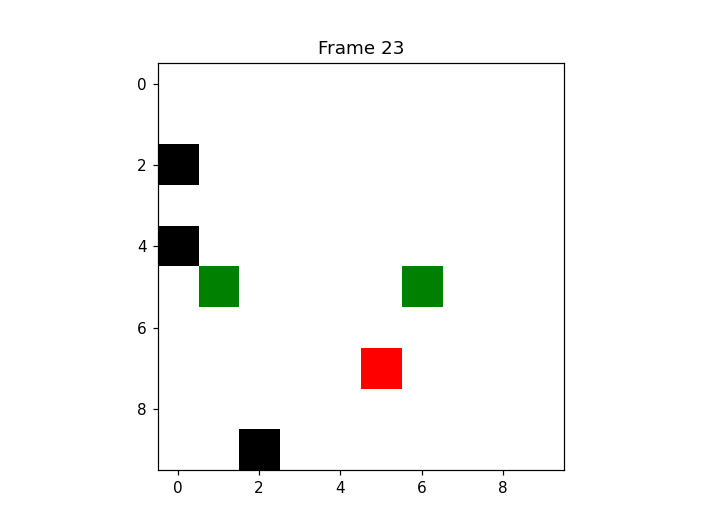

In [192]:
from matplotlib.animation import FuncAnimation
cmap = plt.cm.colors.ListedColormap(['white', 'black', 'green', 'red'])
fig, ax = plt.subplots()
def animate(i):
    ax.imshow(list_matrix[i], cmap=cmap, interpolation='nearest')
    ax.set_title('Frame {}'.format(i))
    return [ax]

# Create the animation
anim = FuncAnimation(fig, animate, frames=len(list_matrix), interval=500, blit=True)

# Show the animation
plt.show()

<IPython.core.display.Javascript object>


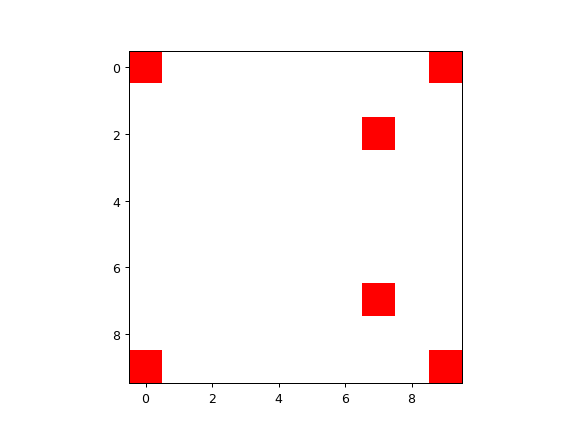

In [174]:


        # Create a plot and show the matrix as cells with the defined colors
        plt.imshow(matrix2, cmap=cmap, interpolation='nearest')
        plt.show()
    

assigned_ids